In [4]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np


def get_objs():
    directory = 'results'
    objs = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and filename.endswith('data'):
            with open(f, 'rb') as filehandle:
                # read the data as binary data stream
                while 1:
                    try:
                        objs.append(pickle.load(filehandle))
                    except EOFError:
                        break
    return objs

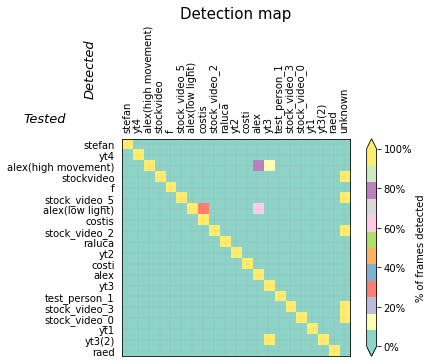

In [12]:

objs = get_objs()


#TODO: get detection percentage out of every person

def generate_matrix_data():
    size = len(objs)
    matrix_data = np.zeros((size, size + 1), dtype=np.float64)
    people_list = []
    mapper = {'unknown': size}

    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx
    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        #print(actual_name, output_faces)
        people_list.append(actual_name)

        for name, count in output_faces.items():
            if name in mapper.keys():
                X = 100 * count / sum(output_faces.values())
                matrix_data[int(mapper[actual_name])][int(mapper[name])] = X
    people_list.append('unknown')

    for i in range(size):
        matrix_data[i][i] = 100
    return matrix_data, people_list


def plot_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, aspect='auto', cmap='YlGn', interpolation='none')
    ax.set_xticks(list(range(len(people_list))))
    ax.set_xticklabels(people_list)
    ax.set_yticks(list(range(len(people_list) - 1)))
    ax.set_yticklabels(people_list[:-1])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.xticks(rotation=90)
    plt.title("Detection map", fontsize=15)
    fig.set_facecolor("white")
    pos_neg_clipped = ax.imshow(arr, cmap='Set3', vmin='0', vmax='100',
                                interpolation='none')
    cbar = fig.colorbar(pos_neg_clipped, ax=ax, format='%.0f%' + '%', spacing='proportional',
                        extend='both',
                        label='% of frames detected')
    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')

    plt.grid(color='r', linestyle='-.', linewidth=0.05)
    plt.show()


matrix_data, people_list = generate_matrix_data()
plot_matrix(matrix_data, people_list)
